# EduRec MOOCCube Course Recommender
> Disentangled Self-Supervision for Recommending Videos in MOOCs (Code using PyTorch). Finding best MOOC course for students based on the past activity

- toc: true
- badges: true
- comments: true
- categories: [PyTorch, Education, Sequence]
- author: "<a href='https://github.com/abinashsinha330/EduRec-Masters-Capstone-Project'>Abinash Sinha</a>"
- image:

## Setup

In [1]:
import os
import math
import copy
import tqdm
import random
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler

## Data Loading

In [2]:
mooccube_df = pd.read_parquet('https://github.com/recohut/reco-data/raw/mooccube/mooccube/v1/interactions_processed.parquet.gzip')
mooccube_df.head()

,id,video_ids,num_video_ids
0,U_8126464,"67,67,230,230,367,367,726,726,1353,1353,1683,1...",187
1,U_8650752,"77,124,274,835,1396,1779,2177,2245,2706,3543,4...",94
2,U_131074,"149,940,2374,3230,6485,6969,10793,10929,12714,...",27
3,U_262145,"1017,3322,4217,4333,4566,4853,5204,5512,6614,6...",43
4,U_1441801,"3494,3494,9388,9845,9845,10364,11164,13695,136...",17


## EDA

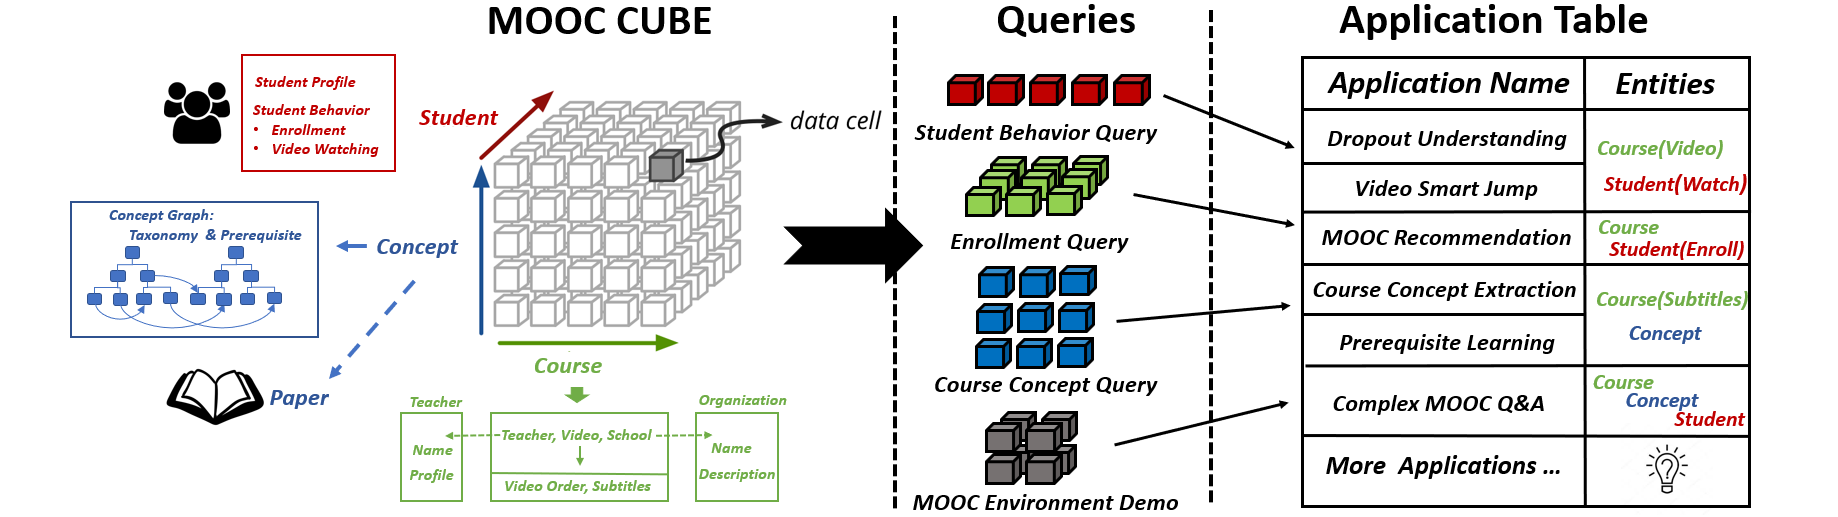

In [30]:
series_num_videos = mooccube_df['num_video_ids']
sum_num_videos = series_num_videos.sum()
avg_num_videos = series_num_videos.mean()
median_num_videos = series_num_videos.median()
first_quartile = series_num_videos.quantile(q=0.25)
third_quartile = series_num_videos.quantile(q=0.75)
max_num_videos = series_num_videos.max()
min_num_videos = series_num_videos.min()
num_students = mooccube_df.shape[0]

item_set = set()
for _, row in mooccube_df.iterrows():
    items = row['video_ids'].split(',')
    item_set = item_set | set(items)

num_uniq_videos = len(item_set)

print('Total number of students: {}'.format(num_students))
print('Number of unique videos watched: {}'.format(num_uniq_videos))
print('Number of videos watched: {}'.format(sum_num_videos))
print('Average number of videos watched: {}'.format(round(avg_num_videos, 2)))
print('Median number of videos watched: {}'.format(median_num_videos))
print('1st quartile number of videos watched: {}'.format(first_quartile))
print('3rd quartile of videos watched: {}'.format(third_quartile))
print('Maximum number of videos watched: {}'.format(max_num_videos))
print('Minimum number of videos watched: {}'.format(min_num_videos))

Total number of students: 48640
Number of unique videos watched: 34101
Number of videos watched: 4874298
Average number of videos watched: 100.21
Median number of videos watched: 59.0
1st quartile number of videos watched: 28.0
3rd quartile of videos watched: 123.0
Maximum number of videos watched: 3427
Minimum number of videos watched: 5


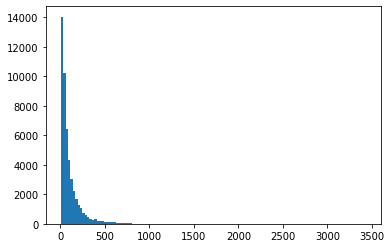

In [32]:
# plot histogram for number of videos watched amongst all students
plt.figure(0)
plt.hist(series_num_videos, bins=128)
plt.show()

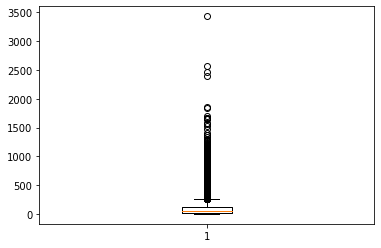

In [33]:
# plot box plot for number of videos watched amongst all students
plt.figure(1)
plt.boxplot(series_num_videos)
plt.show()

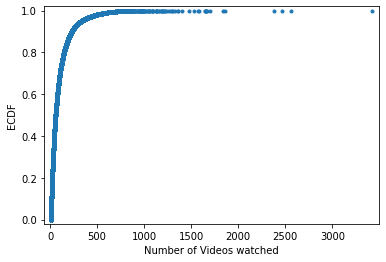

In [34]:
# plot ecdf for number of videos watched amongst all students
x = np.sort(series_num_videos)
y = np.arange(1, len(x) + 1) / len(x)
plt.figure(2)
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Number of Videos watched')
plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

## Utils

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # some cudnn methods can be random even after fixing the seed
    # unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True


def check_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f'{path} created')


def neg_sample(item_set, item_size):
    item = random.randint(1, item_size - 1)
    while item in item_set:
        item = random.randint(1, item_size - 1)
    return item


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, checkpoint_path, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.checkpoint_path = checkpoint_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def compare(self, score):
        for i in range(len(score)):
            if score[i] > self.best_score[i] + self.delta:
                return False
        return True

    def __call__(self, score, model):
        # score HIT@10 NDCG@10

        if self.best_score is None:
            self.best_score = score
            self.score_min = np.array([0] * len(score))
            self.save_checkpoint(score, model)
        elif self.compare(score):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0

    def save_checkpoint(self, score, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            # ({self.score_min:.6f} --> {score:.6f})
            print(f'Validation score increased.  Saving model ...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.score_min = score


def generate_rating_matrix_valid(user_seq, num_users, num_items):
    # three lists are used to construct sparse matrix
    row = []
    col = []
    data = []
    for user_id, item_list in enumerate(user_seq):
        for item in item_list[:-2]:  #
            row.append(user_id)
            col.append(item)
            data.append(1)

    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    rating_matrix = csr_matrix((data, (row, col)), shape=(num_users, num_items))

    return rating_matrix


def generate_rating_matrix_test(user_seq, num_users, num_items):
    # three lists are used to construct sparse matrix
    row = []
    col = []
    data = []
    for user_id, item_list in enumerate(user_seq):
        for item in item_list[:-1]:  #
            row.append(user_id)
            col.append(item)
            data.append(1)

    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    rating_matrix = csr_matrix((data, (row, col)), shape=(num_users, num_items))

    return rating_matrix


def get_user_seqs_csv(data_file):
    data_df = pd.read_csv(data_file)
    user_seq = []
    item_set = set()
    user_set = set()
    for _, row in data_df.iterrows():
        items = row['video_ids'].split(',')
        user_seq.append(items)
        item_set = item_set | set(items)
        user_set.add(row['id'])

    num_users = len(user_set)
    max_item = len(item_set)
    num_items = max_item + 2
    assert len(user_set) == len(user_seq)

    valid_rating_matrix = generate_rating_matrix_valid(user_seq, num_users, num_items)
    test_rating_matrix = generate_rating_matrix_test(user_seq, num_users, num_items)
    return user_seq, max_item, valid_rating_matrix, test_rating_matrix


def get_user_seqs_long_csv(data_file):
    """
    :param data_file:
    :return:
    user_seq:
        list of item sequences
    max_item:
        item with largest item id (number of items basically)
    """
    data_df = pd.read_csv(data_file)
    user_seq = []
    item_set = set()
    user_set = set()
    for idx, row in data_df.iterrows():
        items = row['video_ids'].split(',')
        items = [int(item) for item in items]
        user_seq.append(items)
        item_set = item_set | set(items)
        user_set.add(row['id'])
    max_item = len(item_set)
    assert len(user_set) == len(user_seq)
    return user_seq, max_item


def get_user_seqs_and_sample(data_file, sample_file):
    data_df = pd.read_csv(data_file)
    user_seq = []
    item_set = set()
    for _, row in data_df.iterrows():
        items = row['video_ids'].split(',')
        user_seq.append(items)
        item_set = item_set | set(items)

    max_item = len(item_set)

    sample_df = pd.read_csv(sample_file)
    sample_seq = []
    for _, row in sample_df.iterrows():
        items = row['video_ids'].split(',')
        sample_seq.append(items)
        item_set = item_set | set(items)

    assert len(user_seq) == len(sample_seq)

    return user_seq, max_item, sample_seq


def get_metric(pred_list, topk=10):
    NDCG = 0.0
    HIT = 0.0
    MRR = 0.0
    # [batch] the answer's rank
    for rank in pred_list:
        MRR += 1.0 / (rank + 1.0)
        if rank < topk:
            NDCG += 1.0 / np.log2(rank + 2.0)
            HIT += 1.0
    return HIT / len(pred_list), NDCG / len(pred_list), MRR / len(pred_list)

### Metrics

In [4]:
def precision_at_k_per_sample(actual, predicted, topk):
    num_hits = 0
    for place in predicted:
        if place in actual:
            num_hits += 1
    return num_hits / (topk + 0.0)


def precision_at_k(actual, predicted, topk):
    sum_precision = 0.0
    num_users = len(predicted)
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        sum_precision += len(act_set & pred_set) / float(topk)

    return sum_precision / num_users


def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users


def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum([int(predicted[user_id][j] in
                         set(actual[user_id])) / math.log(j + 2, 2) for j in range(topk)])
        res += dcg_k / idcg
    return res / float(len(actual))


# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

## Pytorch Dataset

In [5]:
class PretrainDataset(Dataset):

    def __init__(self, args, user_seq):
        self.args = args
        self.user_seq = user_seq
        self.max_len = args.max_seq_length
        self.part_sequence = []
        self.split_sequence()

    def split_sequence(self):
        for seq in self.user_seq:
            input_ids = seq[-(self.max_len + 2):-2]  # keeping same as train set
            for i in range(len(input_ids)):
                self.part_sequence.append(input_ids[:(i+1) + 1])

    def __len__(self):
        return len(self.part_sequence)

    def __getitem__(self, index):
        """
        :param index:
        :return:
        """
        # (all possible sequences made using all possible subsets of sequences)
        sequence = self.part_sequence[index]  # pos_items

        seq_len = len(sequence)
        if seq_len == 2:
            t = 1
        else:
            t = torch.randint(1, seq_len-1, (1,))
        # input sub-sequence
        inp_subseq = sequence[:t]
        inp_pad_len = self.max_len - len(inp_subseq)
        inp_pos_items = ([0] * inp_pad_len) + inp_subseq
        inp_pos_items = inp_pos_items[-self.max_len:]

        # label sub-sequence
        label_subseq = sequence[t:]
        label_pad_len = self.max_len - len(label_subseq)
        label_pos_items = [0] * label_pad_len + label_subseq
        label_pos_items = label_pos_items[-self.max_len:]
        label_pos_items.reverse()
        # next item
        next_item = [sequence[t]]

        assert len(inp_pos_items) == self.max_len
        assert len(label_pos_items) == self.max_len

        cur_tensors = (
            torch.tensor(inp_pos_items, dtype=torch.long),  # actual input sub-sequence of items
            torch.tensor(label_pos_items, dtype=torch.long),  # actual label sub-sequence of items
            torch.tensor(next_item, dtype=torch.long)  # item next to input sub-sequence of items
        )

        return cur_tensors


class FineTrainDataset(Dataset):

    def __init__(self, args, user_seq, test_neg_items=None, data_type='train'):
        self.args = args
        self.user_seq = user_seq
        self.test_neg_items = test_neg_items
        self.data_type = data_type
        self.max_len = args.max_seq_length

    def __getitem__(self, index):

        user_id = index
        items = self.user_seq[index]

        assert self.data_type in {"train", "valid", "test"}

        # [0, 1, 2, 3, 4, 5, 6]
        # train [0, 1, 2, 3]
        # target [1, 2, 3, 4]

        # valid [0, 1, 2, 3, 4]
        # answer [5]

        # test [0, 1, 2, 3, 4, 5]
        # answer [6]
        if self.data_type == "train":
            input_ids = items[:-3]
            target_pos = items[1:-2]
            answer = [0]  # no use

        elif self.data_type == 'valid':
            input_ids = items[:-2]
            target_pos = items[1:-1]
            answer = [items[-2]]

        else:
            input_ids = items[:-1]
            target_pos = items[1:]
            answer = [items[-1]]

        target_neg = []
        seq_set = set(items)
        for _ in input_ids:
            target_neg.append(neg_sample(seq_set, self.args.item_size))

        pad_len = self.max_len - len(input_ids)
        input_ids = [0] * pad_len + input_ids
        target_pos = [0] * pad_len + target_pos
        target_neg = [0] * pad_len + target_neg

        input_ids = input_ids[-self.max_len:]
        target_pos = target_pos[-self.max_len:]
        target_neg = target_neg[-self.max_len:]

        assert len(input_ids) == self.max_len
        assert len(target_pos) == self.max_len
        assert len(target_neg) == self.max_len

        if self.test_neg_items is not None:
            test_samples = self.test_neg_items[index]

            cur_tensors = (
                torch.tensor(user_id, dtype=torch.long),  # user_id for testing
                torch.tensor(input_ids, dtype=torch.long),
                torch.tensor(target_pos, dtype=torch.long),
                torch.tensor(target_neg, dtype=torch.long),
                torch.tensor(answer, dtype=torch.long),
                torch.tensor(test_samples, dtype=torch.long),
            )
        else:
            cur_tensors = (
                torch.tensor(user_id, dtype=torch.long),  # user_id for testing
                torch.tensor(input_ids, dtype=torch.long),
                torch.tensor(target_pos, dtype=torch.long),
                torch.tensor(target_neg, dtype=torch.long),
                torch.tensor(answer, dtype=torch.long),
            )

        return cur_tensors

    def __len__(self):
        return len(self.user_seq)

## Custom Pytorch Layers

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias


class Embeddings(nn.Module):
    """Construct the embeddings from item, position.
    """

    def __init__(self, args):
        super(Embeddings, self).__init__()

        self.item_embeddings = nn.Embedding(args.item_size, args.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(args.max_seq_length, args.hidden_size)

        self.LayerNorm = LayerNorm(args.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)

        self.args = args

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        items_embeddings = self.item_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = items_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class SelfAttention(nn.Module):
    def __init__(self, args):
        super(SelfAttention, self).__init__()
        if args.hidden_size % args.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (args.hidden_size, args.num_attention_heads))
        self.num_attention_heads = args.num_attention_heads
        self.attention_head_size = int(args.hidden_size / args.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(args.hidden_size, self.all_head_size)
        self.key = nn.Linear(args.hidden_size, self.all_head_size)
        self.value = nn.Linear(args.hidden_size, self.all_head_size)

        self.attn_dropout = nn.Dropout(args.attention_probs_dropout_prob)
        self.dense = nn.Linear(args.hidden_size, args.hidden_size)
        self.LayerNorm = LayerNorm(args.hidden_size, eps=1e-12)
        self.out_dropout = nn.Dropout(args.hidden_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, input_tensor, attention_mask):
        mixed_query_layer = self.query(input_tensor)
        mixed_key_layer = self.key(input_tensor)
        mixed_value_layer = self.value(input_tensor)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        # [batch_size heads seq_len seq_len] scores
        # [batch_size 1 1 seq_len]
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        # Fixme
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states


class PointWiseFeedForward(nn.Module):
    def __init__(self, args):
        super(PointWiseFeedForward, self).__init__()
        self.conv1d_1 = nn.Conv1d(args.hidden_size, args.hidden_size, kernel_size=(1,))
        self.activation = nn.ReLU()
        self.conv1d_2 = nn.Conv1d(args.hidden_size, args.hidden_size, kernel_size=(1,))
        self.LayerNorm = LayerNorm(args.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)

    def forward(self, input_tensor):

        hidden_states = self.conv1d_1(input_tensor.transpose(1, 2))
        hidden_states = hidden_states.transpose(1, 2)
        hidden_states = self.activation(hidden_states)

        hidden_states = self.conv1d_2(hidden_states.transpose(1, 2))
        hidden_states = hidden_states.transpose(1, 2)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states


class Layer(nn.Module):
    def __init__(self, args):
        super(Layer, self).__init__()
        self.attention = SelfAttention(args)
        self.intermediate = PointWiseFeedForward(args)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        return intermediate_output


class SASEncoder(nn.Module):
    def __init__(self, args):
        super(SASEncoder, self).__init__()
        layer = Layer(args)
        self.layer = nn.ModuleList([copy.deepcopy(layer)
                                    for _ in range(args.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers


class BiasLayer(nn.Module):
    def __init__(self, hidden_size, initializer):
        super(BiasLayer, self).__init__()
        if initializer == 'zeros':
            self.bias = nn.Parameter(torch.zeros(hidden_size))
        elif initializer == 'normal':
            self.bias = nn.Parameter(torch.randn(hidden_size) * (1 / np.sqrt(hidden_size)))

    def forward(self, x):
        return x + self.bias


class DisentangledEncoder(nn.Module):
    def __init__(self, args):
        super(DisentangledEncoder, self).__init__()
        self.sas_encoder = SASEncoder(args)
        # prototypical intention vector for each intention
        self.prototypes = nn.ParameterList([nn.Parameter(torch.zeros(args.hidden_size))
                                            for _ in range(args.num_intents)])

        self.layernorm1 = LayerNorm(args.hidden_size, eps=1e-12)
        self.layernorm2 = LayerNorm(args.hidden_size, eps=1e-12)
        self.layernorm3 = LayerNorm(args.hidden_size, eps=1e-12)
        self.layernorm4 = LayerNorm(args.hidden_size, eps=1e-12)
        self.layernorm5 = LayerNorm(args.hidden_size, eps=1e-12)

        self.w = nn.Linear(args.hidden_size, args.hidden_size)

        self.b_prime = BiasLayer(args.hidden_size, 'zeros')

        # individual alpha for each position
        self.alphas = nn.Parameter(torch.zeros(args.max_seq_length, args.hidden_size))

        self.beta_input_seq = nn.Parameter(torch.randn(args.num_intents, args.hidden_size) *
                                           (1 / np.sqrt(args.hidden_size)))

        self.beta_label_seq = nn.Parameter(torch.randn(args.num_intents, args.hidden_size) *
                                           (1 / np.sqrt(args.hidden_size)))

    def intention_clustering(self, z):
        """
        Method to measure how likely the primary intention at position i
        is related with kth latent category
        :param z:
        :return:
        """
        z = self.layernorm1(z)
        hidden_size = z.shape[2]
        exp_normalized_numerators = list()
        i = 0
        for prototype_k in self.prototypes:
            prototype_k = self.layernorm2(prototype_k)  # [D]
            numerator = torch.matmul(z, prototype_k)  # [B, S]
            exp_normalized_numerator = torch.exp(numerator / np.sqrt(hidden_size))  # [B, S]
            exp_normalized_numerators.append(numerator)
            if i == 0:
                denominator = exp_normalized_numerator
            else:
                denominator = torch.add(denominator, exp_normalized_numerator)
            i = i + 1

        all_attentions_p_k_i = [torch.div(k, denominator)
                                for k in exp_normalized_numerators]  # [B, S] K times
        all_attentions_p_k_i = torch.stack(all_attentions_p_k_i, -1)  # [B, S, K]

        return all_attentions_p_k_i

    def intention_weighting(self, z):
        """
        Method to measure how likely primary intention at position i
        is important for predicting user's future intentions
        :param z:
        :return:
        """
        hidden_size = z.shape[2]
        keys_tilde_i = self.layernorm3(z + self.alphas)  # [B, S, D]
        keys_i = keys_tilde_i + torch.relu(self.w(keys_tilde_i))  # [B, S, D]
        query = self.layernorm4(self.b_prime(self.alphas[-1, :] + (z[:, -1, :])))  # [B, D]
        query = torch.unsqueeze(query, -1)  # [B, D, 1]
        numerators = torch.matmul(keys_i, query)  # [B, S, 1]
        exp_normalized_numerators = torch.exp(numerators / np.sqrt(hidden_size))
        sum_exp_normalized_numerators = exp_normalized_numerators.sum(1).unsqueeze(-1)  # [B, 1] to [B, 1, 1]
        all_attentions_p_i = exp_normalized_numerators / sum_exp_normalized_numerators  # [B, S, 1]
        all_attentions_p_i = all_attentions_p_i.squeeze(-1)  # [B, S]

        return all_attentions_p_i

    def intention_aggr(self, z, attention_weights_p_k_i, attention_weights_p_i, is_input_seq):
        """
        Method to aggregate intentions collected at all positions according
        to both kinds of attention weights
        :param z:
        :param attention_weights_p_k_i:
        :param attention_weights_p_i:
        :param is_input_seq:
        :return:
        """
        attention_weights_p_i = attention_weights_p_i.unsqueeze(-1)  # [B, S, 1]
        attention_weights = torch.mul(attention_weights_p_k_i, attention_weights_p_i)  # [B, S, K]
        attention_weights_transpose = attention_weights.transpose(1, 2)  # [B, K, S]
        if is_input_seq:
            disentangled_encoding = self.beta_input_seq + torch.matmul(attention_weights_transpose, z)
        else:
            disentangled_encoding = self.beta_label_seq + torch.matmul(attention_weights_transpose, z)

        disentangled_encoding = self.layernorm5(disentangled_encoding)

        return disentangled_encoding  # [K, D]

    def forward(self, is_input_seq, hidden_states, attention_mask, output_all_encoded_layers=True):

        z = self.sas_encoder(hidden_states, attention_mask, output_all_encoded_layers)[-1]
        attention_weights_p_k_i = self.intention_clustering(z)  # [B, S, K]
        attention_weights_p_i = self.intention_weighting(z)  # [B, S]
        disentangled_encoding = self.intention_aggr(z,
                                                    attention_weights_p_k_i,
                                                    attention_weights_p_i,
                                                    is_input_seq)

        return disentangled_encoding

## EduRec Pytorch Model

In [7]:
class EduRecModel(nn.Module):
    def __init__(self, args):
        super(EduRecModel, self).__init__()
        self.item_embeddings = nn.Embedding(args.item_size, args.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(args.max_seq_length, args.hidden_size)
        self.sas_encoder = SASEncoder(args)
        self.disentangled_encoder = DisentangledEncoder(args)
        self.LayerNorm = LayerNorm(args.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)
        self.args = args

        self.criterion = nn.BCELoss(reduction='none')
        self.apply(self.init_weights)

    def seq2seqloss(self, inp_subseq_encodings, label_subseq_encodings):
        product = torch.mul(inp_subseq_encodings, label_subseq_encodings)
        normalized_dot_product = torch.sum(product, dim=-1) / np.sqrt(self.args.hidden_size)
        numerator = torch.exp(normalized_dot_product)
        seq2seq_loss_k = -torch.log2(numerator / torch.sum(numerator))
        thresh = np.floor(self.args.lambda_ * self.args.pre_batch_size * self.args.num_intents)
        conf_indicator = seq2seq_loss_k <= thresh
        conf_seq2seq_loss_k = torch.mul(seq2seq_loss_k, conf_indicator)
        seq2seq_loss = torch.sum(conf_seq2seq_loss_k)

        return seq2seq_loss

    def seq2itemloss(self, inp_subseq_encodings, next_item_emb):
        next_item_emb = torch.transpose(next_item_emb, 1, 2)
        dot_product = torch.matmul(inp_subseq_encodings, next_item_emb)  # [B, K, 1]
        exp_normalized_dot_product = torch.exp(dot_product / np.sqrt(self.args.hidden_size))
        numerator = torch.max(exp_normalized_dot_product, dim=1)[0]  # [B, 1]
        seq2item_loss_k = -torch.log2(numerator / torch.sum(exp_normalized_dot_product))  # [B, 1]
        seq2item_loss = torch.sum(seq2item_loss_k)

        return seq2item_loss

    def add_position_embedding(self, sequence):

        seq_length = sequence.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=sequence.device)
        position_ids = position_ids.unsqueeze(0).expand_as(sequence)
        item_embeddings = self.item_embeddings(sequence)
        position_embeddings = self.position_embeddings(position_ids)
        sequence_emb = item_embeddings + position_embeddings
        sequence_emb = self.LayerNorm(sequence_emb)
        sequence_emb = self.dropout(sequence_emb)

        return sequence_emb

    def pretrain(self, inp_pos_items, label_pos_items, next_pos_item):

        next_item_emb = self.item_embeddings(next_pos_item)  # [B, 1, D]

        # Encode masked sequence
        inp_sequence_emb = self.add_position_embedding(inp_pos_items)
        inp_sequence_mask = (inp_pos_items == 0).float() * -1e8
        inp_sequence_mask = torch.unsqueeze(torch.unsqueeze(inp_sequence_mask, 1), 1)

        label_sequence_emb = self.add_position_embedding(label_pos_items)
        label_sequence_mask = (label_pos_items == 0).float() * -1e8
        label_sequence_mask = torch.unsqueeze(torch.unsqueeze(label_sequence_mask, 1), 1)

        inp_seq_encodings = self.disentangled_encoder(True,
                                                      inp_sequence_emb,
                                                      inp_sequence_mask,
                                                      output_all_encoded_layers=True)

        label_seq_encodings = self.disentangled_encoder(False,
                                                        label_sequence_emb,
                                                        label_sequence_mask,
                                                        output_all_encoded_layers=True)

        # seq2item loss
        seq2item_loss = self.seq2itemloss(inp_seq_encodings, next_item_emb)

        # seq2seq loss
        seq2seq_loss = self.seq2seqloss(inp_seq_encodings, label_seq_encodings)

        return seq2item_loss, seq2seq_loss

    # Fine tune
    # same as SASRec
    def finetune(self, input_ids):

        attention_mask = (input_ids > 0).long()
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # torch.int64
        max_len = attention_mask.size(-1)
        attn_shape = (1, max_len, max_len)
        subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)  # torch.uint8
        subsequent_mask = (subsequent_mask == 0).unsqueeze(1)
        subsequent_mask = subsequent_mask.long()

        if self.args.cuda_condition:
            subsequent_mask = subsequent_mask.cuda()

        extended_attention_mask = extended_attention_mask * subsequent_mask
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        sequence_emb = self.add_position_embedding(input_ids)

        item_encoded_layers = self.sas_encoder(sequence_emb,
                                               extended_attention_mask,
                                               output_all_encoded_layers=True)

        sequence_output = item_encoded_layers[-1]
        return sequence_output

    def init_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.args.initializer_range)
        elif isinstance(module, LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

## Model Training

In [8]:
class Trainer:
    def __init__(self, model, train_dataloader,
                 eval_dataloader,
                 test_dataloader, args):

        self.args = args
        self.cuda_condition = torch.cuda.is_available() and not self.args.no_cuda
        self.device = torch.device("cuda" if self.cuda_condition else "cpu")

        self.model = model
        if self.cuda_condition:
            self.model.cuda()

        # Setting the train and test data loader
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.test_dataloader = test_dataloader

        # self.data_name = self.args.data_name
        betas = (self.args.adam_beta1, self.args.adam_beta2)
        self.optim = Adam(self.model.parameters(), lr=self.args.lr, betas=betas, weight_decay=self.args.weight_decay)

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
        self.criterion = nn.BCELoss()

    def train(self, epoch):
        self.iteration(epoch, self.train_dataloader)

    def valid(self, epoch, full_sort=False):
        return self.iteration(epoch, self.eval_dataloader, full_sort, train=False)

    def test(self, epoch, full_sort=False):
        return self.iteration(epoch, self.test_dataloader, full_sort, train=False)

    def iteration(self, epoch, dataloader, full_sort=False, train=True):
        raise NotImplementedError

    def get_sample_scores(self, epoch, pred_list):
        pred_list = (-pred_list).argsort().argsort()[:, 0]
        HIT_1, NDCG_1, MRR = get_metric(pred_list, 1)
        HIT_5, NDCG_5, MRR = get_metric(pred_list, 5)
        HIT_10, NDCG_10, MRR = get_metric(pred_list, 10)
        post_fix = {
            "Epoch": epoch,
            "HIT@1": '{:.4f}'.format(HIT_1), "NDCG@1": '{:.4f}'.format(NDCG_1),
            "HIT@5": '{:.4f}'.format(HIT_5), "NDCG@5": '{:.4f}'.format(NDCG_5),
            "HIT@10": '{:.4f}'.format(HIT_10), "NDCG@10": '{:.4f}'.format(NDCG_10),
            "MRR": '{:.4f}'.format(MRR),
        }
        print(post_fix)
        with open(self.args.log_file, 'a') as f:
            f.write(str(post_fix) + '\n')
        return [HIT_1, NDCG_1, HIT_5, NDCG_5, HIT_10, NDCG_10, MRR], str(post_fix)

    def get_full_sort_score(self, epoch, answers, pred_list):
        recall, ndcg = [], []
        for k in [5, 10, 15, 20]:
            recall.append(recall_at_k(answers, pred_list, k))
            ndcg.append(ndcg_k(answers, pred_list, k))
        post_fix = {
            "Epoch": epoch,
            "HIT@5": '{:.4f}'.format(recall[0]), "NDCG@5": '{:.4f}'.format(ndcg[0]),
            "HIT@10": '{:.4f}'.format(recall[1]), "NDCG@10": '{:.4f}'.format(ndcg[1]),
            "HIT@20": '{:.4f}'.format(recall[3]), "NDCG@20": '{:.4f}'.format(ndcg[3])
        }
        print(post_fix)
        with open(self.args.log_file, 'a') as f:
            f.write(str(post_fix) + '\n')
        return [recall[0], ndcg[0], recall[1], ndcg[1], recall[3], ndcg[3]], str(post_fix)

    def save(self, file_name):
        torch.save(self.model.cpu().state_dict(), file_name)
        self.model.to(self.device)

    def load(self, file_name):
        self.model.load_state_dict(torch.load(file_name))

    def cross_entropy(self, seq_out, pos_ids, neg_ids):
        # [batch seq_len hidden_size]
        pos_emb = self.model.item_embeddings(pos_ids)
        neg_emb = self.model.item_embeddings(neg_ids)
        # [batch*seq_len hidden_size]
        pos = pos_emb.view(-1, pos_emb.size(2))
        neg = neg_emb.view(-1, neg_emb.size(2))
        seq_emb = seq_out.view(-1, self.args.hidden_size)  # [batch*seq_len hidden_size]
        pos_logits = torch.sum(pos * seq_emb, -1)  # [batch*seq_len]
        neg_logits = torch.sum(neg * seq_emb, -1)
        istarget = (pos_ids > 0).view(pos_ids.size(0) * self.model.args.max_seq_length).float()  # [batch*seq_len]
        loss = torch.sum(
            - torch.log(torch.sigmoid(pos_logits) + 1e-24) * istarget -
            torch.log(1 - torch.sigmoid(neg_logits) + 1e-24) * istarget
        ) / torch.sum(istarget)

        return loss

    def predict_sample(self, seq_out, test_neg_sample):
        # [batch 100 hidden_size]
        test_item_emb = self.model.item_embeddings(test_neg_sample)
        # [batch hidden_size]
        test_logits = torch.bmm(test_item_emb, seq_out.unsqueeze(-1)).squeeze(-1)  # [B 100]
        return test_logits

    def predict_full(self, seq_out):
        # [item_num hidden_size]
        test_item_emb = self.model.item_embeddings.weight
        # [batch hidden_size ]
        rating_pred = torch.matmul(seq_out, test_item_emb.transpose(0, 1))
        return rating_pred


class PretrainTrainer(Trainer):

    def __init__(self, model,
                 train_dataloader,
                 eval_dataloader,
                 test_dataloader, args):
        super(PretrainTrainer, self).__init__(
            model,
            train_dataloader,
            eval_dataloader,
            test_dataloader, args
        )

    def pretrain(self, epoch, pretrain_dataloader):
        desc = f'S2I-{self.args.s2i_weight}-' \
               f'S2S-{self.args.s2s_weight}'

        pretrain_data_iter = tqdm.tqdm(enumerate(pretrain_dataloader),
                                       desc=f"{self.args.model_name}-{self.args.data_name} Epoch:{epoch}",
                                       total=len(pretrain_dataloader),
                                       bar_format="{l_bar}{r_bar}")

        self.model.train()
        seq2item_loss_avg = 0.0
        seq2seq_loss_avg = 0.0
        total_loss_avg = 0.0

        for i, batch in pretrain_data_iter:
            # 0. batch_data will be sent into the device(GPU or CPU)
            batch = tuple(t.to(self.device) for t in batch)
            inp_pos_items, label_pos_items, next_pos_item = batch

            seq2item_loss, seq2seq_loss = self.model.pretrain(inp_pos_items, label_pos_items, next_pos_item)

            joint_loss = self.args.s2i_weight * seq2item_loss + \
                         self.args.s2s_weight * seq2seq_loss

            self.optim.zero_grad()
            joint_loss.backward()
            self.optim.step()
            # print('seq2item loss', seq2item_loss.item())
            # print('seq2seq loss', seq2seq_loss.item())
            seq2item_loss_avg += seq2item_loss.item()
            seq2seq_loss_avg += seq2seq_loss.item()
            total_loss_avg += (seq2item_loss_avg + seq2seq_loss_avg)

        num = len(pretrain_data_iter) * self.args.pre_batch_size
        post_fix = {
            "epoch": epoch,
            "seq2item_loss_avg": '{:.4f}'.format(seq2item_loss_avg / num),
            "seq2seq_loss_avg": '{:.4f}'.format(seq2seq_loss_avg / num),
            "total_loss_avg": '{:.4f}'.format(total_loss_avg / num)
        }
        print(desc)
        print(str(post_fix))
        with open(self.args.log_file, 'a') as f:
            f.write(str(desc) + '\n')
            f.write(str(post_fix) + '\n')


class FinetuneTrainer(Trainer):

    def __init__(self, model,
                 train_dataloader,
                 eval_dataloader,
                 test_dataloader, args):
        super(FinetuneTrainer, self).__init__(
            model,
            train_dataloader,
            eval_dataloader,
            test_dataloader, args
        )

    def iteration(self, epoch, dataloader, full_sort=False, train=True):

        str_code = "train" if train else "test"

        # Setting the tqdm progress bar
        rec_data_iter = tqdm.tqdm(enumerate(dataloader),
                                  desc="Recommendation EP_%s:%d" % (str_code, epoch),
                                  total=len(dataloader),
                                  bar_format="{l_bar}{r_bar}")
        if train:
            self.model.train()
            rec_avg_loss = 0.0
            rec_cur_loss = 0.0

            for i, batch in rec_data_iter:
                # 0. batch_data will be sent into the device(GPU or CPU)
                batch = tuple(t.to(self.device) for t in batch)
                _, input_ids, target_pos, target_neg, _ = batch
                # Binary cross_entropy
                sequence_output = self.model.finetune(input_ids)
                loss = self.cross_entropy(sequence_output, target_pos, target_neg)
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                rec_avg_loss += loss.item()
                rec_cur_loss = loss.item()

            post_fix = {
                "epoch": epoch,
                "rec_avg_loss": '{:.4f}'.format(rec_avg_loss / len(rec_data_iter)),
                "rec_cur_loss": '{:.4f}'.format(rec_cur_loss),
            }

            if (epoch + 1) % self.args.log_freq == 0:
                print(str(post_fix))

            with open(self.args.log_file, 'a') as f:
                f.write(str(post_fix) + '\n')

        else:
            self.model.eval()

            pred_list = None

            if full_sort:
                answer_list = None
                for i, batch in rec_data_iter:
                    # 0. batch_data will be sent into the device(GPU or cpu)
                    batch = tuple(t.to(self.device) for t in batch)
                    user_ids, input_ids, target_pos, target_neg, answers = batch
                    recommend_output = self.model.finetune(input_ids)

                    recommend_output = recommend_output[:, -1, :]

                    rating_pred = self.predict_full(recommend_output)

                    rating_pred = rating_pred.cpu().data.numpy().copy()
                    batch_user_index = user_ids.cpu().numpy()
                    rating_pred[self.args.train_matrix[batch_user_index].toarray() > 0] = 0
                    # reference: https://stackoverflow.com/a/23734295, https://stackoverflow.com/a/20104162
                    ind = np.argpartition(rating_pred, -20)[:, -20:]
                    arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]
                    arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]
                    batch_pred_list = ind[np.arange(len(rating_pred))[:, None], arr_ind_argsort]

                    if i == 0:
                        pred_list = batch_pred_list
                        answer_list = answers.cpu().data.numpy()
                    else:
                        pred_list = np.append(pred_list, batch_pred_list, axis=0)
                        answer_list = np.append(answer_list, answers.cpu().data.numpy(), axis=0)
                return self.get_full_sort_score(epoch, answer_list, pred_list)

            else:
                for i, batch in rec_data_iter:
                    # 0. batch_data will be sent into the device(GPU or cpu)
                    batch = tuple(t.to(self.device) for t in batch)
                    user_ids, input_ids, target_pos, target_neg, answers, sample_negs = batch
                    recommend_output = self.model.finetune(input_ids)
                    test_neg_items = torch.cat((answers, sample_negs), -1)
                    recommend_output = recommend_output[:, -1, :]

                    test_logits = self.predict_sample(recommend_output, test_neg_items)
                    test_logits = test_logits.cpu().detach().numpy().copy()
                    if i == 0:
                        pred_list = test_logits
                    else:
                        pred_list = np.append(pred_list, test_logits, axis=0)

                return self.get_sample_scores(epoch, pred_list)

## Start the Learning

> Note: We are training only for 3 epochs just to validate the functionality as our focus is on undertanding the overall process of this type of modeling.

In [10]:
mooccube_df.to_csv('mooccube.csv', index=False)

In [ ]:
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument('--data_dir', default='.', type=str)
    parser.add_argument('--plot_dir', default='plot', type=str)
    parser.add_argument('--output_dir', default='output', type=str)
    parser.add_argument('--data_name', default='mooccube', type=str)

    # model args
    parser.add_argument("--model_name", default='Pretrain', type=str)

    parser.add_argument("--hidden_size", type=int, default=64, help="hidden size of transformer model")
    parser.add_argument("--num_hidden_layers", type=int, default=2, help="number of layers")
    parser.add_argument('--num_attention_heads', default=1, type=int)
    parser.add_argument('--hidden_act', default="gelu", type=str)  # gelu relu
    parser.add_argument("--attention_probs_dropout_prob", type=float, default=0.5, help="attention dropout p")
    parser.add_argument("--hidden_dropout_prob", type=float, default=0.5, help="hidden dropout p")
    parser.add_argument("--initializer_range", type=float, default=0.02)
    parser.add_argument('--max_seq_length', default=50, type=int)
    parser.add_argument('--num_intents', default=4, type=int)
    parser.add_argument('--lambda_', default=0.5, type=float)

    # train args
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate of adam")
    parser.add_argument("--batch_size", type=int, default=128, help="number of batch_size")
    parser.add_argument("--epochs", type=int, default=200, help="number of epochs")
    parser.add_argument("--no_cuda", action="store_true")
    parser.add_argument("--log_freq", type=int, default=1, help="per epoch print res")
    parser.add_argument("--seed", default=42, type=int)

    # pre train args
    parser.add_argument("--pre_epochs", type=int, default=300, help="number of pre_train epochs")
    parser.add_argument("--pre_batch_size", type=int, default=100)
    parser.add_argument('--ckp', default=20, type=int, help="pretrain epochs 10, 20, 30...")

    parser.add_argument("--mask_p", type=float, default=0.2, help="mask probability")
    parser.add_argument("--s2i_weight", type=float, default=1.0, help="seq2item loss weight")
    parser.add_argument("--s2s_weight", type=float, default=1.0, help="seq2seq loss weight")

    parser.add_argument("--weight_decay", type=float, default=0.0, help="weight_decay of adam")
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam second beta value")
    parser.add_argument("--gpu_id", type=str, default="0", help="gpu_id")

    args = parser.parse_args(args=[])

    set_seed(args.seed)
    check_path(args.output_dir)

    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
    args.cuda_condition = torch.cuda.is_available() and not args.no_cuda

    args.data_file = os.path.join(args.data_dir, args.data_name + '.csv')

    user_seq, max_item = get_user_seqs_long_csv(args.data_file)
    # args.ckp = 20
    args_str = f'{args.model_name}-{args.data_name}-epochs-{args.ckp}'
    checkpoint = args_str + '.pt'
    args.checkpoint_path = os.path.join(args.output_dir, checkpoint)

    args.item_size = max_item + 2
    args.mask_id = max_item + 1
    # save model args
    args_str = f'{args.model_name}-{args.data_name}'
    args.log_file = os.path.join(args.output_dir, args_str + '.txt')
    print(args)
    with open(args.log_file, 'a') as f:
        f.write(str(args) + '\n')

    model = EduRecModel(args=args)
    trainer = PretrainTrainer(model, None, None, None, args)

    # to resume training from last trained epoch
    if os.path.exists(args.checkpoint_path):
        trainer.load(args.checkpoint_path)
        print(f'Resume training from epoch={args.ckp} for pre-training!')
        init_epoch = int(args.ckp)
    else:
        init_epoch = -1
    for epoch in range(args.pre_epochs):
        if epoch <= init_epoch:
          continue
        pretrain_dataset = PretrainDataset(args, user_seq)
        pretrain_sampler = RandomSampler(pretrain_dataset)
        pretrain_dataloader = DataLoader(pretrain_dataset, sampler=pretrain_sampler, batch_size=args.pre_batch_size)

        trainer.pretrain(epoch, pretrain_dataloader)

        # if (epoch + 1) % 10 == 0:
        ckp = f'{args.model_name}-{args.data_name}-epochs-{epoch+1}.pt'
        checkpoint_path = os.path.join(args.output_dir, ckp)
        trainer.save(checkpoint_path)


main()

Namespace(adam_beta1=0.9, adam_beta2=0.999, attention_probs_dropout_prob=0.5, batch_size=128, checkpoint_path='output/Pretrain-mooccube-epochs-20.pt', ckp=20, cuda_condition=True, data_dir='.', data_file='./mooccube.csv', data_name='mooccube', epochs=200, gpu_id='0', hidden_act='gelu', hidden_dropout_prob=0.5, hidden_size=64, initializer_range=0.02, item_size=34103, lambda_=0.5, log_file='output/Pretrain-mooccube.txt', log_freq=1, lr=0.001, mask_id=34102, mask_p=0.2, max_seq_length=50, model_name='Pretrain', no_cuda=False, num_attention_heads=1, num_hidden_layers=2, num_intents=4, output_dir='output', plot_dir='plot', pre_batch_size=100, pre_epochs=300, s2i_weight=1.0, s2s_weight=1.0, seed=42, weight_decay=0.0)
Total Parameters: 2295616


Pretrain-mooccube Epoch:0: 100%|| 18708/18708 [09:38<00:00, 32.35it/s]


S2I-1.0-S2S-1.0
{'epoch': 0, 'seq2item_loss_avg': '6.8654', 'seq2seq_loss_avg': '34.5771', 'total_loss_avg': '389116.3282'}


Pretrain-mooccube Epoch:1: 100%|| 18708/18708 [09:43<00:00, 32.07it/s]


S2I-1.0-S2S-1.0
{'epoch': 1, 'seq2item_loss_avg': '6.6616', 'seq2seq_loss_avg': '34.5748', 'total_loss_avg': '385779.0027'}


Pretrain-mooccube Epoch:2: 100%|| 18708/18708 [09:50<00:00, 31.69it/s]


S2I-1.0-S2S-1.0
{'epoch': 2, 'seq2item_loss_avg': '6.6537', 'seq2seq_loss_avg': '34.5746', 'total_loss_avg': '385690.2441'}


Pretrain-mooccube Epoch:3:  31%|| 5715/18708 [02:58<06:41, 32.36it/s]